In [2]:
%matplotlib inline
%load_ext ipycache

import pandas as pd
import numpy as np
import scipy
import sklearn as sk
import xgboost as xgb

from eli5 import show_weights

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache


In [4]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [
        (math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 
        for i,pred in enumerate(y_pred)
    ]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

def rmse(y, y_pred):
    return np.sqrt(((y_pred - y) ** 2).mean())

# Препроцессинг фич

In [369]:
# train_raw = pd.read_csv("data/train.csv")
train_raw = pd.read_csv("data/train_without_noise.csv")
macro = pd.read_csv("data/macro.csv")
train_raw.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [370]:
def preprocess_anomaly(df):
    df["full_sq"] = map(lambda x: x if x > 10 else float("NaN"), df["full_sq"])
    df["life_sq"] = map(lambda x: x if x > 5 else float("NaN"), df["life_sq"])
    df["kitch_sq"] = map(lambda x: x if x > 2 else float("NaN"), df["kitch_sq"])
#     full_sq-life_sq<0 full_sq-kitch_sq<0 life_sq-kitch_sq<0 floor-max_floor<0
    return df

In [371]:
def preprocess_categorial(df):
    df = mess_y_categorial(df, 5)
    df = df.select_dtypes(exclude=['object'])
    return df

def apply_categorial(test, train):
    test = mess_y_categorial_fold(test, train)
    test = test.select_dtypes(exclude=['object'])
    return test


def smoothed_likelihood(targ_mean, nrows, globalmean, alpha=10):
    try:
        return (targ_mean * nrows + globalmean * alpha) / (nrows + alpha)
    except Exception:
        return float("NaN")


def mess_y_categorial(df, nfolds=3, alpha=10):
    from sklearn.utils import shuffle
    from copy import copy

    folds = np.array_split(shuffle(df), nfolds)
    newfolds = []
    for i in range(nfolds):
        fold = folds[i]

        other_folds = copy(folds)
        other_folds.pop(i)
        other_fold = pd.concat(other_folds)

        newfolds.append(mess_y_categorial_fold(fold, other_fold, alpha=10))

    return pd.concat(newfolds)

def mess_y_categorial_fold(fold_raw, other_fold, cols=None, y_col="price_doc", alpha=10):
    fold = fold_raw.copy()
    if not cols:
        cols = list(fold.select_dtypes(include=["object"]).columns)
    globalmean = other_fold[y_col].mean()
    for c in cols:

        target_mean = other_fold[[c, y_col]].groupby(c).mean().to_dict()[y_col]
        nrows = other_fold[c].value_counts().to_dict()

        fold[c + "_sll"] = fold[c].apply(
            lambda x: smoothed_likelihood(target_mean.get(x), nrows.get(x), globalmean, alpha) if x else float("NaN")
        )
    return fold

In [372]:
def apply_macro(df):
    macro_cols = [
        'timestamp', "balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
        "micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
        "income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"
    ]
    return pd.merge(df, macro, on='timestamp', how='left')

In [373]:
def preprocess(df):
    from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
    
#     df = apply_macro(df)
    
#     df["timestamp_year"] = df["timestamp"].apply(lambda x: x.split("-")[0])
#     df["timestamp_month"] = df["timestamp"].apply(lambda x: x.split("-")[1])
#     df["timestamp_year_month"] = df["timestamp"].apply(lambda x: x.split("-")[0] + "-" + x.split("-")[1]) 

    df = df.drop(["id", "timestamp"], axis=1)

    ecology = ["no data", "poor", "satisfactory", "good", "excellent"]
    df["ecology_index"] = map(ecology.index, df["ecology"].values)
    
    bool_feats = [
        "thermal_power_plant_raion",
        "incineration_raion",
        "oil_chemistry_raion",
        "radiation_raion",
        "railroad_terminal_raion",
        "big_market_raion",
        "nuclear_reactor_raion",
        "detention_facility_raion",
        "water_1line",
        "big_road1_1line",
        "railroad_1line",
        "culture_objects_top_25"
    ]
    for bf in bool_feats:
        df[bf + "_bool"] = map(lambda x: x == "yes", df[bf].values)

    df = preprocess_anomaly(df)

    df['rel_floor'] = df['floor'] / df['max_floor'].astype(float)
    df['rel_kitch_sq'] = df['kitch_sq'] / df['full_sq'].astype(float)
    df['rel_life_sq'] = df['life_sq'] / df['full_sq'].astype(float)

    df["material_cat"] = df.material.fillna(0).astype(int).astype(str).replace("0", "")
    df["state_cat"] = df.state.fillna(0).astype(int).astype(str).replace("0", "")

#     df["age_of_building"] = df["timestamp_year"].astype(float) - df["build_year"].astype(float)

    df["num_room_cat"] = df.num_room.fillna(0).astype(int).astype(str).replace("0", "")

    return df

In [374]:
# train_raw["price_doc"] = np.log1p(train_raw["price_doc"].values)

train_pr = preprocess(train_raw)
train = preprocess_categorial(train_pr)
train = train.fillna(-1)

X = train.drop(["price_doc"], axis=1)
y = train["price_doc"].values

# Обучение моделей

In [375]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X.values, y, test_size=0.20, random_state=43)

dtrain_all = xgb.DMatrix(X.values, y, feature_names=X.columns)
dtrain = xgb.DMatrix(X_train, y_train, feature_names=X.columns)
dval = xgb.DMatrix(X_val, y_val, feature_names=X.columns)

In [376]:
xgb_params = {
    'max_depth': 5,
    'n_estimators': 200,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
model = xgb.train(xgb_params, dtrain, num_boost_round=2000, evals=[(dval, 'val')],
                  early_stopping_rounds=40, verbose_eval=40)

num_boost_round = model.best_iteration

[0]	val-rmse:8.18105e+06
Will train until val-rmse hasn't improved in 40 rounds.
[40]	val-rmse:5.84753e+06
[80]	val-rmse:4.41844e+06
[120]	val-rmse:3.59168e+06
[160]	val-rmse:3.15409e+06
[200]	val-rmse:2.92998e+06
[240]	val-rmse:2.81863e+06
[280]	val-rmse:2.762e+06
[320]	val-rmse:2.73116e+06
[360]	val-rmse:2.71531e+06
[400]	val-rmse:2.70434e+06
[440]	val-rmse:2.69486e+06
[480]	val-rmse:2.68622e+06
[520]	val-rmse:2.67812e+06
[560]	val-rmse:2.67135e+06
[600]	val-rmse:2.66673e+06
[640]	val-rmse:2.66158e+06
[680]	val-rmse:2.65696e+06
[720]	val-rmse:2.65344e+06
[760]	val-rmse:2.65052e+06
[800]	val-rmse:2.64762e+06
[840]	val-rmse:2.64509e+06
[880]	val-rmse:2.64208e+06
[920]	val-rmse:2.63956e+06
[960]	val-rmse:2.63772e+06
[1000]	val-rmse:2.63657e+06
[1040]	val-rmse:2.63533e+06
[1080]	val-rmse:2.63418e+06
[1120]	val-rmse:2.63305e+06
[1160]	val-rmse:2.63226e+06
[1200]	val-rmse:2.63064e+06
[1240]	val-rmse:2.62959e+06
[1280]	val-rmse:2.62815e+06
[1320]	val-rmse:2.62728e+06
[1360]	val-rmse:2.62624

[0]	train-rmse:8.41615e+06+58054.6	test-rmse:8.41716e+06+116561
[40]	train-rmse:6.02691e+06+42346.7	test-rmse:6.07837e+06+102351
[80]	train-rmse:4.51644e+06+32094.5	test-rmse:4.63427e+06+93436.1
[120]	train-rmse:3.58738e+06+27467.2	test-rmse:3.77603e+06+79514.4
[160]	train-rmse:3.03287e+06+24978.1	test-rmse:3.29726e+06+68990.7
[200]	train-rmse:2.70987e+06+23363.6	test-rmse:3.04471e+06+63796.3
[240]	train-rmse:2.51902e+06+20561.5	test-rmse:2.91147e+06+60630.6
[280]	train-rmse:2.40303e+06+18519	test-rmse:2.83979e+06+57547.3
[320]	train-rmse:2.32832e+06+16507.2	test-rmse:2.79944e+06+55304.3
[360]	train-rmse:2.27524e+06+13547.4	test-rmse:2.77595e+06+55858.6
[400]	train-rmse:2.23501e+06+12167.9	test-rmse:2.76001e+06+56344.9
[440]	train-rmse:2.2013e+06+9987.45	test-rmse:2.74812e+06+57855.9
[480]	train-rmse:2.17181e+06+8388.07	test-rmse:2.73749e+06+57790.1
[520]	train-rmse:2.14692e+06+7958	test-rmse:2.72925e+06+56712.6
[560]	train-rmse:2.12481e+06+8950.27	test-rmse:2.72305e+06+55623.5
[600]	t

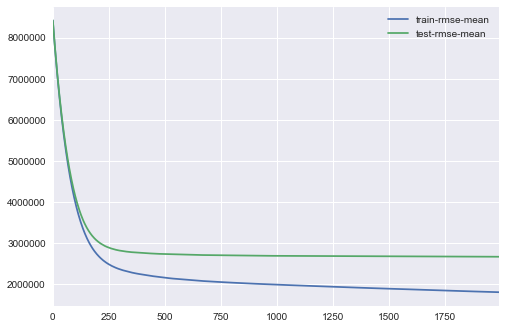

In [377]:
cv_output = xgb.cv(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round, verbose_eval=40)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [378]:
model = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=num_boost_round, verbose_eval=40)
print "predict-train:", rmse(model.predict(dtrain_all), y)

predict-train: 1899129.43771


In [152]:
model = xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.01, nthread=-1, silent=False)
model.fit(X.values, y, verbose=20)

with open("scores.tsv", "a") as sf:
    sf.write("%s\n" % rmsle(model.predict(X.values), y))

!tail scores.tsv

0.600060083922
0.600143342353
0.600373787948
0.600353068955
0.46439283026
0.46439283026
0.358629272177
0.169248212931
0.169248212931
0.600353068955


In [206]:
show_weights(model, feature_names=list(X.columns), importance_type="weight")

AttributeError: 'Booster' object has no attribute 'booster'

In [148]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def validate(clf):
    cval = np.abs(cross_val_score(clf, X.values, y, cv=3, 
                                  scoring=make_scorer(rmsle, False), verbose=2))
    return np.mean(cval), cval

print validate(model)

[CV]  ................................................................
[CV] ................................................. , total= 3.3min
[CV]  ................................................................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s



[CV] ................................................. , total= 3.5min
[CV]  ................................................................
[CV] ................................................. , total= 3.4min
(0.48691991486317548, array([ 0.53821961,  0.48457595,  0.43796419]))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.2min finished


# Submission

In [379]:
test = pd.read_csv("data/test.csv")

test_pr = preprocess(test)
test_pr = apply_categorial(test_pr, train_pr)
test_pr = test_pr.fillna(-1)

dtest = xgb.DMatrix(test_pr.values, feature_names=test_pr.columns)
y_pred = model.predict(dtest)

# y_pred = model.predict(test_pr.values)

# y_pred = np.exp(y_pred) - 1

submdf = pd.DataFrame({"id": test["id"], "price_doc": y_pred})
submdf.to_csv("data/submission.csv", header=True, index=False)
!head data/submission.csv

id,price_doc
30474,5497280.0
30475,8215873.5
30476,5590106.0
30477,5920538.0
30478,5153178.0
30479,7994372.5
30480,4415410.5
30481,3930074.0
30482,4644629.0


without noise xgb logarithmic y

    val-rmse:0.478924

macro 10*400
    
    val-rmse:0.480618

macro 5*200

    val-rmse:0.476849

macro 5*200 no month and year

    val-rmse:0.477861

macro 5*200 no month and year
    
    val-rmse:0.473012

macro 5*200 no month and year

    val-rmse:0.471758
    predict-train: 0.427215115875

macro 5*200 no month and year, train_without_noise

    val-rmse:0.461684
    train-rmse:0.411116+0.00299259	test-rmse:0.472202+0.00166791
    predict-train: 0.423849149218
    kaggle: 0.36027

5*200, no macro no add features, train_without_noise:
    
    val-rmse:0.471989
    train-rmse:0.425924+0.00643495	test-rmse:0.473873+0.0131213
    predict-train: 0.43508730101

5*200, no macro add rel features, train_without_noise:

    val-rmse:0.471808
    train-rmse:0.425264+0.00595741	test-rmse:0.47383+0.0130655
    predict-train: 0.435635092773
    kaggle: 0.32837

5*200, no macro, add rel features, no log price, train_without_noise:
    
    val-rmse:2.63772e+06
    train-rmse:1.9989e+06+10986.4	test-rmse:2.69158e+06+53020
    predict-train: 2076010.27131
    kaggle: 0.31720

5*200, no macro, add rel features, no log price, train_with_noise:

    val-rmse:2.53378e+06
    train-rmse:1.95069e+06+16166.4	test-rmse:2.69703e+06+61455.1
    predict-train: 2054421.59869
    kaggle: 0.32056

5*200, macro, add rel features, no log price, train_without_noise:
    
    val-rmse:2.79632e+06
    train-rmse:1.81015e+06+19781.2	test-rmse:2.6641e+06+123875
    predict-train: 1904063.27368
    kaggle: 0.32976

5*200, no macro, add rel features, no log price, train_without_noise:
    
    val-rmse:2.61682e+06
    train-rmse:1.81123e+06+27681.2	test-rmse:2.66923e+06+53925.7
    predict-train: 1899129.43771